In [1]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import walk
import random

np.random.seed(1337)  # for reproducibility

def setGPU():
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    #config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))
setGPU()

print('libs loaded')

Using TensorFlow backend.


libs loaded


In [2]:
# parameters
data_path = '../data/seg_data/{}/'
size = 128

def load_filenames(path):
    filenames = []
    for (dirpath, dirnames, filenames) in walk(data_path.format('x')):
        filenames.extend(filenames)
        break
    for f in filenames:
        if not '.npy' in f:
            del f
    training_filenames = []
    validation_filenames = []
    for f in filenames:
        if 'case1_' in f:
            validation_filenames.append(f)
        else:
            training_filenames.append(f)
            
            
    return training_filenames, validation_filenames
    
training_filenames, validation_filenames = load_filenames(data_path)

print(training_filenames)
print(validation_filenames)

['case10_label11.npy', 'case6_label11.npy', 'case8_label11.npy', 'case10_label6.npy', 'case9_label19.npy', 'case2_label13.npy', 'case9_label7.npy', 'case5_label3.npy', 'case6_label15.npy', 'case6_label8.npy', 'case10_label4.npy', 'case9_label13.npy', 'case3_label6.npy', 'case2_label5.npy', 'case9_label12.npy', 'case6_label9.npy', 'case9_label17.npy', 'case9_label10.npy', 'case8_label12.npy', 'case8_label4.npy', 'case4_label14.npy', 'case9_label5.npy', 'case4_label6.npy', 'case8_label5.npy', 'case5_label8.npy', 'case4_label3.npy', 'case8_label9.npy', 'case8_label18.npy', 'case8_label15.npy', 'case6_label19.npy', 'case8_label10.npy', 'case9_label8.npy', 'case4_label11.npy', 'case5_label17.npy', 'case4_label12.npy', 'case3_label16.npy', 'case2_label8.npy', 'case2_label7.npy', 'case8_label19.npy', 'case3_label7.npy', 'case8_label8.npy', 'case4_label19.npy', 'case3_label15.npy', 'case6_label6.npy', 'case5_label18.npy', 'case4_label15.npy', 'case5_label5.npy', 'case4_label4.npy', 'case5_labe

In [7]:

def model():
    from keras.models import Model
    from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, BatchNormalization, Activation, Dense, Flatten
    
    def conv(input_tensor, depth):
        conv_tensor = Conv3D(depth, 3, padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
        bn = BatchNormalization()(conv_tensor) # use_bias=False
        output_tensor = Activation('relu')(bn)
        return output_tensor
    
    def pool(input_tensor):
        output_tensor = MaxPooling3D(pool_size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def up(input_tensor):
        output_tensor = UpSampling3D(size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def skip(input_tensor1, input_tensor2):
        output_tensor = Concatenate(axis=-1)([input_tensor1, input_tensor2])
        return output_tensor
    
    input_img = Input(shape=(size, size, size, 1))
    
    conv1 = conv(input_img, 8)
    conv2 = conv(conv1, 8)
    
    pool1 = pool(conv2)
    
    conv3 = conv(pool1, 16)
    conv4 = conv(conv3, 16)
    
    pool2 = pool(conv4)
    
    conv5 = conv(pool2, 32)
    conv6 = conv(conv5, 32)
    
    pool3 = pool(conv6)
    
    conv7 = conv(pool3, 64)
    conv8 = conv(conv7, 64)

    pool4 = pool(conv8)
    
    conv9 = conv(pool4, 128)
    conv10 = conv(conv9, 128)
    
    flat = Flatten()(conv10)
    
    dense1 = Dense(units = 1024, activation = 'relu')(flat)
    
    output_cat = Dense(units = 20, activation = 'softmax')(dense1)

    
    # model
    model = Model(inputs=input_img, outputs=output_cat)
    print (model.output_shape)

    # optimizer
    opt = keras.optimizers.Adam(lr=1e-4)#32-5,16-3
    
    model.compile(optimizer=opt,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

model = model()

(None, 20)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 128, 1)  0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 128, 128, 128, 8)  224       
_________________________________________________________________
batch_normalization_21 (Batc (None, 128, 128, 128, 8)  32        
_________________________________________________________________
activation_21 (Activation)   (None, 128, 128, 128, 8)  0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 128, 128, 128, 8)  1736      
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 128, 8)  32        
_________________________________________________________________
activation_22 (Activation)   (None, 128, 128, 128, 8)  0         

In [8]:
import re

def generator(batch_size, filenames):
    while 1:
        shape = (batch_size, size, size, size, 1)
        shape2 = (batch_size, 20)
        
        x_out = np.zeros(shape)
        y_out2 = np.zeros(shape2)
        
        for i in range(batch_size):
            filename = random.choice(filenames)
            x = np.load(data_path.format('y') + filename)
            #print(filename)
            x = np.reshape(x, (size, size, size, -1))
            
            x_out[i] = x
            
            label = int(re.sub("\D", "", filename.split('.')[0].split('_')[1]))
            label_one_hot = [0] * 20
            label_one_hot[label] = 1
            
            y_out2[i] = label_one_hot
            #print(label_one_hot)
            
        yield (x_out, y_out2)

In [9]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss',
#                                min_delta=0,
#                                patience=2,
#                                verbose=0,
#                                mode='auto')
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('./save/model.weights.best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='min') 

history = model.fit_generator(  generator(8, training_filenames),
                                validation_data=generator(16, validation_filenames),
                                steps_per_epoch=10,
                                validation_steps = 10,
                                epochs=2000,
                                callbacks=[checkpoint])

Epoch 1/2000
10/10 [==============================] - 20s 2s/step - loss: 8.4843 - acc: 0.1125 - val_loss: 3.1266 - val_acc: 0.1437
Epoch 2/2000
10/10 [==============================] - 12s 1s/step - loss: 5.7634 - acc: 0.3125 - val_loss: 3.3186 - val_acc: 0.0187
Epoch 3/2000
10/10 [==============================] - 12s 1s/step - loss: 6.7009 - acc: 0.3625 - val_loss: 3.2478 - val_acc: 0.0375
Epoch 4/2000
10/10 [==============================] - 12s 1s/step - loss: 4.5889 - acc: 0.5000 - val_loss: 3.5486 - val_acc: 0.0625
Epoch 5/2000
10/10 [==============================] - 12s 1s/step - loss: 5.2480 - acc: 0.5750 - val_loss: 3.4083 - val_acc: 0.0500
Epoch 6/2000
10/10 [==============================] - 12s 1s/step - loss: 4.6942 - acc: 0.6000 - val_loss: 3.5905 - val_acc: 0.0563
Epoch 7/2000
10/10 [==============================] - 12s 1s/step - loss: 4.8342 - acc: 0.6375 - val_loss: 3.5773 - val_acc: 0.0437
Epoch 8/2000
10/10 [==============================] - 12s 1s/step - loss: 3.

Epoch 34/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0298 - acc: 0.7500 - val_loss: 3.8519 - val_acc: 0.4062
Epoch 35/2000
10/10 [==============================] - 12s 1s/step - loss: 3.2238 - acc: 0.8000 - val_loss: 3.6797 - val_acc: 0.5125
Epoch 36/2000
10/10 [==============================] - 12s 1s/step - loss: 2.4179 - acc: 0.8500 - val_loss: 3.7786 - val_acc: 0.4562
Epoch 37/2000
10/10 [==============================] - 12s 1s/step - loss: 2.2164 - acc: 0.8625 - val_loss: 4.3399 - val_acc: 0.4125
Epoch 38/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0223 - acc: 0.8125 - val_loss: 3.8339 - val_acc: 0.5188
Epoch 39/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0297 - acc: 0.7500 - val_loss: 4.5421 - val_acc: 0.4437
Epoch 40/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0223 - acc: 0.8125 - val_loss: 4.0288 - val_acc: 0.4625
Epoch 41/2000
10/10 [==============================] - 12s 1s/step - 

10/10 [==============================] - 12s 1s/step - loss: 2.4178 - acc: 0.8500 - val_loss: 3.7535 - val_acc: 0.5188
Epoch 68/2000
10/10 [==============================] - 12s 1s/step - loss: 6.2458 - acc: 0.6125 - val_loss: 4.3820 - val_acc: 0.4500
Epoch 69/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0296 - acc: 0.7500 - val_loss: 4.0167 - val_acc: 0.5125
Epoch 79/2000
10/10 [==============================] - 12s 1s/step - loss: 5.2384 - acc: 0.6750 - val_loss: 4.7065 - val_acc: 0.4750
Epoch 80/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0296 - acc: 0.7500 - val_loss: 3.3866 - val_acc: 0.5188
Epoch 81/2000
10/10 [==============================] - 12s 1s/step - loss: 2.8207 - acc: 0.8250 - val_loss: 4.3127 - val_acc: 0.5125
Epoch 82/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.8039 - val_acc: 0.5125
Epoch 83/2000
10/10 [==============================] - 12s 1s/step - loss: 5.2384 -

10/10 [==============================] - 12s 1s/step - loss: 2.8207 - acc: 0.8250 - val_loss: 4.4295 - val_acc: 0.5500
Epoch 110/2000
10/10 [==============================] - 12s 1s/step - loss: 2.4177 - acc: 0.8500 - val_loss: 4.0947 - val_acc: 0.4813
Epoch 111/2000
10/10 [==============================] - 12s 1s/step - loss: 3.4251 - acc: 0.7875 - val_loss: 4.1823 - val_acc: 0.5437
Epoch 112/2000
10/10 [==============================] - 12s 1s/step - loss: 3.2236 - acc: 0.8000 - val_loss: 3.9020 - val_acc: 0.6375
Epoch 113/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 4.6299 - val_acc: 0.5938
Epoch 114/2000
10/10 [==============================] - 12s 1s/step - loss: 4.4325 - acc: 0.7250 - val_loss: 4.3488 - val_acc: 0.5437
Epoch 115/2000
10/10 [==============================] - 12s 1s/step - loss: 5.0369 - acc: 0.6875 - val_loss: 3.9714 - val_acc: 0.5687
Epoch 116/2000
10/10 [==============================] - 12s 1s/step - loss: 4

Epoch 142/2000
10/10 [==============================] - 12s 1s/step - loss: 4.8354 - acc: 0.7000 - val_loss: 4.0838 - val_acc: 0.6062
Epoch 143/2000
10/10 [==============================] - 12s 1s/step - loss: 2.0148 - acc: 0.8750 - val_loss: 4.7028 - val_acc: 0.5625
Epoch 144/2000
10/10 [==============================] - 12s 1s/step - loss: 4.6340 - acc: 0.7125 - val_loss: 3.5112 - val_acc: 0.6375
Epoch 145/2000
10/10 [==============================] - 12s 1s/step - loss: 4.4325 - acc: 0.7250 - val_loss: 3.6175 - val_acc: 0.6375
Epoch 146/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 4.1191 - val_acc: 0.6188
Epoch 147/2000
10/10 [==============================] - 12s 1s/step - loss: 2.4177 - acc: 0.8500 - val_loss: 3.1663 - val_acc: 0.6625
Epoch 148/2000
10/10 [==============================] - 12s 1s/step - loss: 3.2236 - acc: 0.8000 - val_loss: 3.2595 - val_acc: 0.6500
Epoch 149/2000
10/10 [==============================] - 12s 1s

Epoch 175/2000
10/10 [==============================] - 12s 1s/step - loss: 4.2310 - acc: 0.7375 - val_loss: 3.3217 - val_acc: 0.6375
Epoch 176/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.9004 - val_acc: 0.5875
Epoch 177/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 3.3694 - val_acc: 0.6375
Epoch 178/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 4.0320 - val_acc: 0.6375
Epoch 179/2000
10/10 [==============================] - 12s 1s/step - loss: 4.4325 - acc: 0.7250 - val_loss: 3.9009 - val_acc: 0.6062
Epoch 180/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0222 - acc: 0.8125 - val_loss: 3.8681 - val_acc: 0.6250
Epoch 181/2000
10/10 [==============================] - 12s 1s/step - loss: 4.6340 - acc: 0.7125 - val_loss: 3.3629 - val_acc: 0.6937
Epoch 182/2000
10/10 [==============================] - 12s 1s

Epoch 208/2000
10/10 [==============================] - 12s 1s/step - loss: 3.2236 - acc: 0.8000 - val_loss: 4.2465 - val_acc: 0.6062
Epoch 209/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 4.2859 - val_acc: 0.5687
Epoch 210/2000
10/10 [==============================] - 12s 1s/step - loss: 1.6118 - acc: 0.9000 - val_loss: 4.1317 - val_acc: 0.5500
Epoch 211/2000
10/10 [==============================] - 12s 1s/step - loss: 3.8281 - acc: 0.7625 - val_loss: 3.7231 - val_acc: 0.6062
Epoch 212/2000
10/10 [==============================] - 12s 1s/step - loss: 4.6340 - acc: 0.7125 - val_loss: 3.7390 - val_acc: 0.6188
Epoch 213/2000
10/10 [==============================] - 12s 1s/step - loss: 3.4251 - acc: 0.7875 - val_loss: 4.2590 - val_acc: 0.6000
Epoch 214/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.9656 - val_acc: 0.6250
Epoch 215/2000
10/10 [==============================] - 12s 1s

Epoch 241/2000
10/10 [==============================] - 12s 1s/step - loss: 3.2236 - acc: 0.8000 - val_loss: 3.9795 - val_acc: 0.6125
Epoch 242/2000
10/10 [==============================] - 12s 1s/step - loss: 3.2236 - acc: 0.8000 - val_loss: 3.5626 - val_acc: 0.6438
Epoch 243/2000
10/10 [==============================] - 12s 1s/step - loss: 3.8281 - acc: 0.7625 - val_loss: 4.0667 - val_acc: 0.6000
Epoch 244/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0221 - acc: 0.8125 - val_loss: 3.6525 - val_acc: 0.6312
Epoch 245/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0221 - acc: 0.8125 - val_loss: 3.4184 - val_acc: 0.6188
Epoch 246/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.1743 - val_acc: 0.6375
Epoch 247/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0221 - acc: 0.8125 - val_loss: 3.6529 - val_acc: 0.6250
Epoch 248/2000
10/10 [==============================] - 12s 1s

Epoch 274/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0221 - acc: 0.8125 - val_loss: 3.9081 - val_acc: 0.6500
Epoch 275/2000
10/10 [==============================] - 12s 1s/step - loss: 4.2310 - acc: 0.7375 - val_loss: 4.3623 - val_acc: 0.5938
Epoch 276/2000
10/10 [==============================] - 12s 1s/step - loss: 3.8281 - acc: 0.7625 - val_loss: 4.0367 - val_acc: 0.6250
Epoch 277/2000
10/10 [==============================] - 12s 1s/step - loss: 2.8207 - acc: 0.8250 - val_loss: 3.0963 - val_acc: 0.6312
Epoch 278/2000
10/10 [==============================] - 12s 1s/step - loss: 5.0369 - acc: 0.6875 - val_loss: 3.6902 - val_acc: 0.6062
Epoch 279/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.8915 - val_acc: 0.5750
Epoch 280/2000
10/10 [==============================] - 12s 1s/step - loss: 3.2236 - acc: 0.8000 - val_loss: 3.8300 - val_acc: 0.6438
Epoch 281/2000
10/10 [==============================] - 15s 1s

10/10 [==============================] - 15s 1s/step - loss: 2.8207 - acc: 0.8250 - val_loss: 2.4525 - val_acc: 0.7375
Epoch 307/2000
10/10 [==============================] - 12s 1s/step - loss: 3.4251 - acc: 0.7875 - val_loss: 3.6427 - val_acc: 0.6312
Epoch 308/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 3.4877 - val_acc: 0.6188
Epoch 309/2000
10/10 [==============================] - 12s 1s/step - loss: 4.2310 - acc: 0.7375 - val_loss: 3.2470 - val_acc: 0.6813
Epoch 310/2000
10/10 [==============================] - 12s 1s/step - loss: 4.2310 - acc: 0.7375 - val_loss: 4.3049 - val_acc: 0.5437
Epoch 311/2000
10/10 [==============================] - 12s 1s/step - loss: 2.8207 - acc: 0.8250 - val_loss: 3.0717 - val_acc: 0.6500
Epoch 312/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 4.5466 - val_acc: 0.5938
Epoch 313/2000
10/10 [==============================] - 12s 1s/step - loss: 3

Epoch 340/2000
10/10 [==============================] - 12s 1s/step - loss: 3.8281 - acc: 0.7625 - val_loss: 4.8263 - val_acc: 0.5687
Epoch 341/2000
10/10 [==============================] - 12s 1s/step - loss: 3.4251 - acc: 0.7875 - val_loss: 4.6497 - val_acc: 0.5750
Epoch 342/2000
10/10 [==============================] - 12s 1s/step - loss: 3.8280 - acc: 0.7625 - val_loss: 5.2117 - val_acc: 0.5563
Epoch 343/2000
10/10 [==============================] - 12s 1s/step - loss: 4.8354 - acc: 0.7000 - val_loss: 3.8206 - val_acc: 0.6438
Epoch 344/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 3.3900 - val_acc: 0.6375
Epoch 345/2000
10/10 [==============================] - 12s 1s/step - loss: 4.4325 - acc: 0.7250 - val_loss: 3.6393 - val_acc: 0.6250
Epoch 346/2000
10/10 [==============================] - 12s 1s/step - loss: 4.2310 - acc: 0.7375 - val_loss: 2.8390 - val_acc: 0.6937
Epoch 347/2000
10/10 [==============================] - 12s 1s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 1555/2000
10/10 [==============================] - 12s 1s/step - loss: 4.8354 - acc: 0.7000 - val_loss: 4.0845 - val_acc: 0.6250
Epoch 1556/2000
10/10 [==============================] - 12s 1s/step - loss: 3.8280 - acc: 0.7625 - val_loss: 4.2083 - val_acc: 0.6000
Epoch 1557/2000
10/10 [==============================] - 12s 1s/step - loss: 4.4325 - acc: 0.7250 - val_loss: 3.6187 - val_acc: 0.6125
Epoch 1558/2000
10/10 [==============================] - 12s 1s/step - loss: 4.2310 - acc: 0.7375 - val_loss: 4.6473 - val_acc: 0.5625
Epoch 1559/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.5043 - val_acc: 0.6562
Epoch 1560/2000
10/10 [==============================] - 12s 1s/step - loss: 5.0369 - acc: 0.6875 - val_loss: 4.3924 - val_acc: 0.6000
Epoch 1561/2000
10/10 [==============================] - 13s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.2879 - val_acc: 0.5813
Epoch 1562/2000
10/10 [==============================] 

Epoch 1588/2000
10/10 [==============================] - 12s 1s/step - loss: 3.8280 - acc: 0.7625 - val_loss: 3.3300 - val_acc: 0.6438
Epoch 1589/2000
10/10 [==============================] - 12s 1s/step - loss: 3.4251 - acc: 0.7875 - val_loss: 3.6269 - val_acc: 0.6438
Epoch 1590/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0221 - acc: 0.8125 - val_loss: 3.9712 - val_acc: 0.5813
Epoch 1591/2000
10/10 [==============================] - 12s 1s/step - loss: 4.4325 - acc: 0.7250 - val_loss: 3.6001 - val_acc: 0.6125
Epoch 1592/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 3.7501 - val_acc: 0.6125
Epoch 1593/2000
10/10 [==============================] - 12s 1s/step - loss: 2.8207 - acc: 0.8250 - val_loss: 3.4599 - val_acc: 0.6250
Epoch 1594/2000
10/10 [==============================] - 12s 1s/step - loss: 3.2236 - acc: 0.8000 - val_loss: 3.4652 - val_acc: 0.6125
Epoch 1595/2000
10/10 [==============================] 

Epoch 1621/2000
10/10 [==============================] - 12s 1s/step - loss: 4.6340 - acc: 0.7125 - val_loss: 3.4714 - val_acc: 0.6125
Epoch 1622/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.6536 - val_acc: 0.6813
Epoch 1623/2000
10/10 [==============================] - 12s 1s/step - loss: 3.8280 - acc: 0.7625 - val_loss: 4.1840 - val_acc: 0.5938
Epoch 1624/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0221 - acc: 0.8125 - val_loss: 3.6918 - val_acc: 0.6125
Epoch 1625/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 4.0871 - val_acc: 0.5687
Epoch 1626/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 2.5088 - val_acc: 0.6813
Epoch 1627/2000
10/10 [==============================] - 12s 1s/step - loss: 4.4325 - acc: 0.7250 - val_loss: 2.7458 - val_acc: 0.7125
Epoch 1628/2000
10/10 [==============================] 

Epoch 1654/2000
10/10 [==============================] - 12s 1s/step - loss: 4.4325 - acc: 0.7250 - val_loss: 3.6711 - val_acc: 0.5500
Epoch 1655/2000
10/10 [==============================] - 12s 1s/step - loss: 4.4325 - acc: 0.7250 - val_loss: 4.8631 - val_acc: 0.5250
Epoch 1656/2000
10/10 [==============================] - 12s 1s/step - loss: 5.8428 - acc: 0.6375 - val_loss: 3.2113 - val_acc: 0.6875
Epoch 1657/2000
10/10 [==============================] - 12s 1s/step - loss: 3.8280 - acc: 0.7625 - val_loss: 3.8765 - val_acc: 0.6062
Epoch 1658/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.1727 - val_acc: 0.6312
Epoch 1659/2000
10/10 [==============================] - 12s 1s/step - loss: 4.4325 - acc: 0.7250 - val_loss: 3.2681 - val_acc: 0.6375
Epoch 1660/2000
10/10 [==============================] - 12s 1s/step - loss: 2.4177 - acc: 0.8500 - val_loss: 3.9768 - val_acc: 0.6062
Epoch 1661/2000
10/10 [==============================] 

Epoch 1687/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 4.3885 - val_acc: 0.6375
Epoch 1688/2000
10/10 [==============================] - 12s 1s/step - loss: 4.6340 - acc: 0.7125 - val_loss: 3.9354 - val_acc: 0.6250
Epoch 1689/2000
10/10 [==============================] - 12s 1s/step - loss: 2.4177 - acc: 0.8500 - val_loss: 4.2604 - val_acc: 0.5625
Epoch 1690/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 5.0268 - val_acc: 0.5625
Epoch 1691/2000
10/10 [==============================] - 12s 1s/step - loss: 5.0369 - acc: 0.6875 - val_loss: 3.9552 - val_acc: 0.6125
Epoch 1692/2000
10/10 [==============================] - 12s 1s/step - loss: 4.2310 - acc: 0.7375 - val_loss: 4.8613 - val_acc: 0.5625
Epoch 1693/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 3.3405 - val_acc: 0.6375
Epoch 1694/2000
10/10 [==============================] 

Epoch 1720/2000
10/10 [==============================] - 12s 1s/step - loss: 5.2384 - acc: 0.6750 - val_loss: 4.3605 - val_acc: 0.5687
Epoch 1721/2000
10/10 [==============================] - 12s 1s/step - loss: 4.2310 - acc: 0.7375 - val_loss: 4.5949 - val_acc: 0.6125
Epoch 1722/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 3.7216 - val_acc: 0.6375
Epoch 1723/2000
10/10 [==============================] - 12s 1s/step - loss: 3.2236 - acc: 0.8000 - val_loss: 3.3796 - val_acc: 0.6000
Epoch 1724/2000
10/10 [==============================] - 13s 1s/step - loss: 3.2236 - acc: 0.8000 - val_loss: 3.8720 - val_acc: 0.5563
Epoch 1725/2000
10/10 [==============================] - 12s 1s/step - loss: 3.4251 - acc: 0.7875 - val_loss: 4.0564 - val_acc: 0.5625
Epoch 1726/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0221 - acc: 0.8125 - val_loss: 3.9834 - val_acc: 0.6312
Epoch 1727/2000
10/10 [==============================] 

Epoch 1753/2000
10/10 [==============================] - 12s 1s/step - loss: 4.6340 - acc: 0.7125 - val_loss: 3.1271 - val_acc: 0.6438
Epoch 1754/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 4.6381 - val_acc: 0.5750
Epoch 1755/2000
10/10 [==============================] - 12s 1s/step - loss: 2.6192 - acc: 0.8375 - val_loss: 4.4321 - val_acc: 0.6000
Epoch 1756/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 3.8252 - val_acc: 0.6188
Epoch 1757/2000
10/10 [==============================] - 12s 1s/step - loss: 3.6266 - acc: 0.7750 - val_loss: 4.3951 - val_acc: 0.6375
Epoch 1758/2000
10/10 [==============================] - 12s 1s/step - loss: 4.2310 - acc: 0.7375 - val_loss: 3.0288 - val_acc: 0.6875
Epoch 1759/2000
10/10 [==============================] - 12s 1s/step - loss: 2.0148 - acc: 0.8750 - val_loss: 2.9400 - val_acc: 0.6562
Epoch 1760/2000
10/10 [==============================] 

Epoch 1786/2000
10/10 [==============================] - 12s 1s/step - loss: 2.6192 - acc: 0.8375 - val_loss: 4.6587 - val_acc: 0.5625
Epoch 1787/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 3.9070 - val_acc: 0.6000
Epoch 1788/2000
10/10 [==============================] - 12s 1s/step - loss: 4.2310 - acc: 0.7375 - val_loss: 3.0439 - val_acc: 0.6813
Epoch 1789/2000
10/10 [==============================] - 12s 1s/step - loss: 3.8280 - acc: 0.7625 - val_loss: 2.9220 - val_acc: 0.7000
Epoch 1790/2000
10/10 [==============================] - 12s 1s/step - loss: 4.6340 - acc: 0.7125 - val_loss: 3.6009 - val_acc: 0.5938
Epoch 1791/2000
10/10 [==============================] - 12s 1s/step - loss: 3.4251 - acc: 0.7875 - val_loss: 3.2066 - val_acc: 0.7000
Epoch 1792/2000
10/10 [==============================] - 12s 1s/step - loss: 3.2236 - acc: 0.8000 - val_loss: 4.1585 - val_acc: 0.5875
Epoch 1793/2000
10/10 [==============================] 

Epoch 1819/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 3.5067 - val_acc: 0.6687
Epoch 1820/2000
10/10 [==============================] - 12s 1s/step - loss: 4.6340 - acc: 0.7125 - val_loss: 4.0970 - val_acc: 0.6687
Epoch 1821/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0221 - acc: 0.8125 - val_loss: 3.9336 - val_acc: 0.6625
Epoch 1822/2000
10/10 [==============================] - 12s 1s/step - loss: 3.4251 - acc: 0.7875 - val_loss: 3.9953 - val_acc: 0.6188
Epoch 1823/2000
10/10 [==============================] - 12s 1s/step - loss: 5.8428 - acc: 0.6375 - val_loss: 3.8129 - val_acc: 0.6625
Epoch 1824/2000
10/10 [==============================] - 12s 1s/step - loss: 4.0295 - acc: 0.7500 - val_loss: 3.0856 - val_acc: 0.6813
Epoch 1825/2000
10/10 [==============================] - 12s 1s/step - loss: 3.0221 - acc: 0.8125 - val_loss: 3.8986 - val_acc: 0.6813
Epoch 1826/2000
10/10 [==============================] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
def plot_result():
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_result()

In [11]:

#model.save_weights('./save/model_weights.h5')

In [25]:
del model

case1_label18.npy


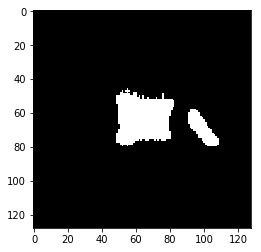

In [20]:
filename = validation_filenames[4]
print(filename)
x = np.load(data_path.format('y') + filename)
plt.imshow(x[:,:,65], cmap='gray')
x = np.reshape(x, (1, 128, 128, 128, -1))

In [21]:
y_cat = model.predict(x)
print(y_cat[0])
print(max(y_cat[0]))
print(np.argmax(y_cat))

[2.8869637e-14 4.0498807e-10 9.9699491e-07 2.0664469e-07 3.8215671e-09
 8.4189816e-07 8.0334378e-04 1.3019018e-03 1.8544814e-14 2.2101672e-17
 3.2913383e-07 4.4113173e-24 1.3121414e-03 8.8527027e-05 6.6095449e-02
 5.3827543e-02 6.8143286e-02 5.4505121e-17 8.0260152e-01 5.8238781e-03]
0.8026015
18


In [ ]:
y = np.load(data_path.format('y') + validation_filenames[0])
plt.imshow(y[:,:,65], cmap='gray')

In [40]:
model.save_weights('./save/model.label.weights.final.h5')
#model.load_weights('./save/model.weights.best.h5')

In [26]:
import random
import re

def generator(batch_size, filenames):
    size = 128
    
    shape = (batch_size, size, size, size, 1)

    x_out = np.zeros(shape)
    y_out = np.zeros(shape)

    for i in range(batch_size):
        filename = random.choice(filenames)
        #filename = filenames[0]
        x = np.load(data_path.format('x') + filename)
        y = np.load(data_path.format('y') + filename)
        x = np.reshape(x, (size, size, size, -1))
        y = np.reshape(y, (size, size, size, -1))

        x_out[i] = x
        y_out[i] = y
    
        print(filename.split('_')[0])
        print(int(re.sub("\D", "", filename.split('_')[0])))
        
        label = int(re.sub("\D", "", filename.split('_')[0]))
        y_out2 = [0] * 20
        y_out2[label] = 1
        print(y_out2)
        
generator(1, training_filenames)

case9
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
print(random.randint(-2,2))

1


In [25]:
    x_bias, y_bias, z_bias = random.randint(-2,2), random.randint(-2,2), random.randint(-2,2)
    x_range = (x_bias, 127) if x_bias > 0 else (0, size + x_bias -1)
    y_range = (y_bias, 127) if y_bias > 0 else (0, size + y_bias -1)
    z_range = (z_bias, 127) if z_bias > 0 else (0, size + z_bias -1)
    print(x_range)

(0, 125)
